In [1]:
''' Script to clean data (remove Nan, impute, normalize etc) from the pickle objects
'''

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14})   
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import csv
import pandas as pd
from pandasql import sqldf
import pickle

#dump/read functions
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

#load raw data object
DATA_raw = load_obj('DATA-raw')

#store all cleaned data
FileNo = list(DATA_raw.keys())

# ['FileNo', 'FieldName', 'Prod', 'Prod_Control', 'Cumm', 'Loc', 'Comp']
attributes = list(DATA_raw['18782'].keys())
DATA_clean = dict((fno, dict((attr, None) for attr in attributes)) for fno in FileNo)

In [2]:
#split all objects into list/matrices
num_wells = len(FileNo)
FileNo_ = []
FieldName_ = []
Prod_ = []
Prod_Control_ = []
Cumm_ = []
Loc_ = []
Comp_ = []

for f in FileNo:
    FileNo_.append(DATA_raw[f]['FileNo'])
    FieldName_.append(DATA_raw[f]['FieldName'])
    Prod_.append(DATA_raw[f]['Prod'])
    Prod_Control_.append(DATA_raw[f]['Prod_Control'])
    Cumm_.append(DATA_raw[f]['Cumm'])
    Loc_.append(DATA_raw[f]['Loc'])
    Comp_.append(DATA_raw[f]['Comp'])
    
#convert to numpy matrices
FileNo_ = np.array(FileNo_)
FieldName_ = np.array(FieldName_)
Prod_ = np.array(Prod_)
Prod_Control_ = np.array(Prod_Control_)
Cumm_ = np.array(Cumm_)
Loc_ = np.array(Loc_)
Comp_ = np.array(Comp_)

print(FileNo_.shape)
print(FieldName_.shape)
print(Prod_.shape)
print(Prod_Control_.shape)
print(Cumm_.shape)
print(Loc_.shape)
print(Comp_.shape)

#some stats
print("No of unique fields : ", len(np.unique(FieldName_)))

(886,)
(886,)
(886, 130, 3)
(886, 130)
(886, 3)
(886, 2)
(886, 5)
No of unique fields :  199


In [3]:
#function to normalize output by features: [num_data, timesteps, features]
def normalizeOutput(data):
    output_maxs = np.zeros([data.shape[1], data.shape[2]]) 
    output_maxs[:, 0] = np.max(data[:, :, 0])
    output_maxs[:, 1] = np.max(data[:, :, 1]) 
    output_maxs[:, 2] = np.max(data[:, :, 2]) 
    return (data/(output_maxs)), output_maxs

def check_stats(data):
    print(data.shape)
    print(np.min(data))
    print(np.max(data))
    
def plot_wells(data, controls, fileno):
    plt.figure(figsize=[14, 14])
    for i in range(15):
        ax1 = plt.subplot(5, 3, i+1)

        #shift to view other sets
        i = i + 0

        _ = data[i]
        ax1.plot(_[:, 2], c='r', label='Gas', alpha=0.8)
        ax1.plot(_[:, 1], c='b', label='Water', alpha=0.8)
        ax1.plot(_[:, 0], c='g', label='Oil', alpha=0.8)
        ax1.legend()
        ax1.set_xlabel('Timesteps')
        ax1.set_ylabel('Rate')
        ax1.set_title(fileno[i])

        ax2 = ax1.twinx() 
        c = 'tab:purple'

        #plot control on another axis
        _ = controls[i]
        ax2.plot(_, color=c)
        ax2.set_ylabel('Control', color=c) 
        ax2.tick_params(axis ='y', labelcolor=c)
        
        ax1.grid(False)
        ax2.grid(False)

    plt.tight_layout()

(886, 130, 3)
0.0
2000.0
(886, 130, 3)
0.0
1.0


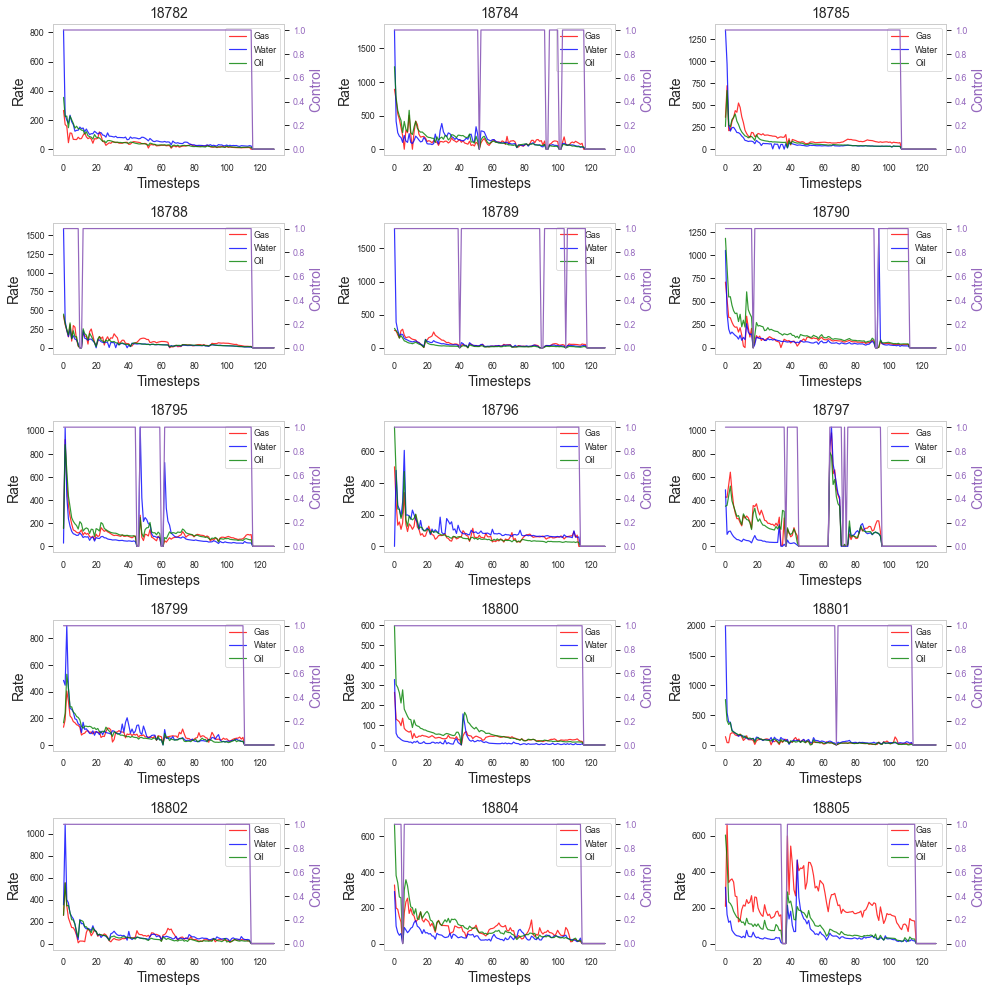

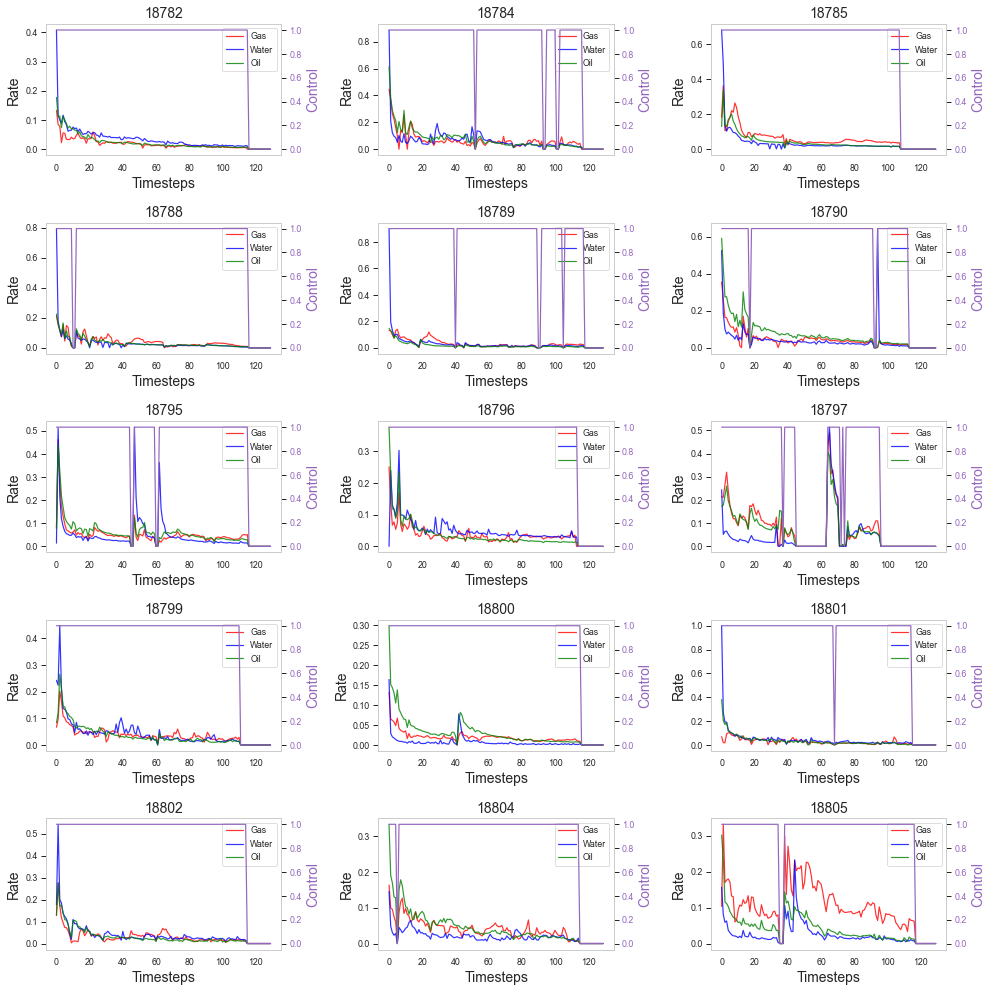

In [4]:
#'Prod' = 'BBLS_Oil'+'BBLS_Water'+'MCF_Prod'

#check the max with a histogram and truncate
Prod_[Prod_ > 2000] = 2000

#normalize production data by channel
Prod_norm, Prod_maxs = normalizeOutput(Prod_)

#quality check
check_stats(Prod_)
check_stats(Prod_norm)

#quality check production profiles (the first 15 wells)
plot_wells(Prod_, Prod_Control_, FileNo_)
plot_wells(Prod_norm, Prod_Control_, FileNo_)

(886, 3)
15053
1000000
(886, 3)
0.017072
1.0


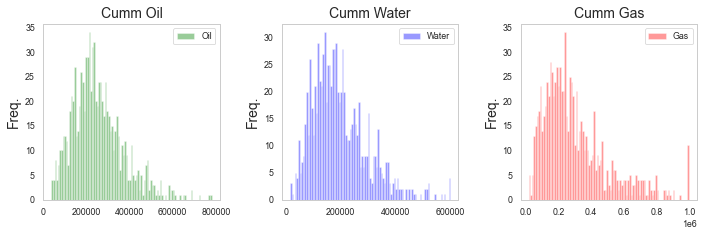

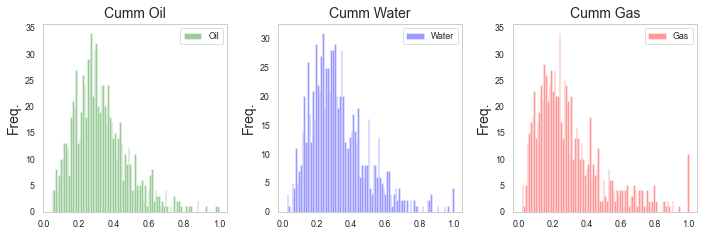

In [5]:
#'Cumm' = 'Cumm_Oil', 'Cumm_Water', 'Cumm_Gas',

#function to normalize cumms by features: [num_data, features]
def normalizeCumm(data):
    output_maxs = np.zeros([data.shape[1],])
    output_maxs[0] = np.max(data[:, 0])
    output_maxs[1] = np.max(data[:, 1]) 
    output_maxs[2] = np.max(data[:, 2]) 
    return (data/(output_maxs)), output_maxs

def plot_hists(data):
    plt.figure(figsize=[10, 3.5])
    
    clrs = ['green', 'blue', 'red']
    lbls = ['Oil', 'Water', 'Gas']
    titles = ['Cumm Oil', 'Cumm Water', 'Cumm Gas']
    
    for i in range(len(lbls)):
        plt.subplot(1, 3, i+1)
        bb = np.linspace(np.min(data[:, i]), np.max(data[:, i]), 100)
        plt.hist(data[:, i], color=clrs[i], alpha=0.4, bins=bb, label=lbls[i])
        plt.title(titles[i])
        plt.ylabel("Freq.")
        plt.legend()
        plt.grid(False)
    plt.tight_layout()
    
#remove outliers in cumms
#set hard limit (refer to histogram for these thresholds)
thresholds = [800000, 0.6e6, 1e6]
for i in range(len(thresholds)):
    Cumm_[Cumm_[:, i] > thresholds[i], i] = thresholds[i]
                 
#normalize cumulative data by channel
Cumm_norm, Cumm_maxs = normalizeCumm(Cumm_)

#quality check
check_stats(Cumm_)
check_stats(Cumm_norm)

#quality check by features 
plot_hists(Cumm_)
plot_hists(Cumm_norm)

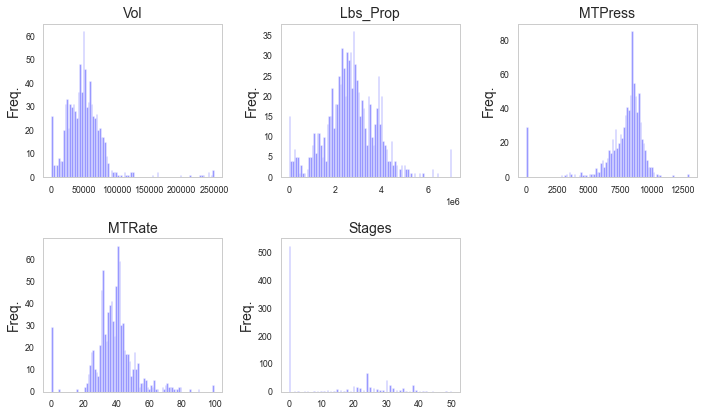

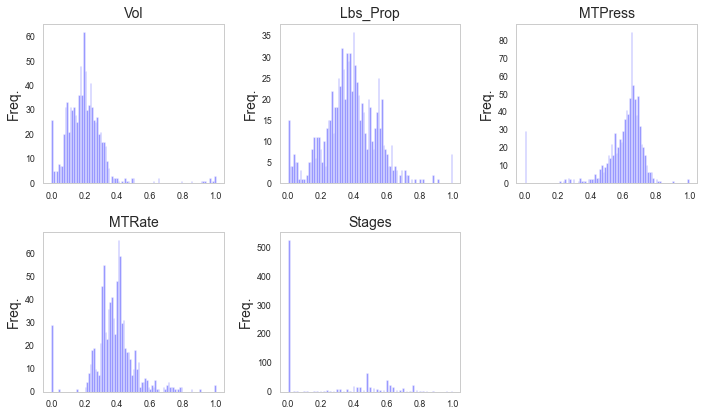

In [6]:
#'Comp' = 'Vol', 'Lbs_Prop', 'MTPress', 'MTRate_N', 'Stages'

def plot_hists(data):
    plt.figure(figsize=[10, 6])
    
    titles = ['Vol', 'Lbs_Prop', 'MTPress', 'MTRate', 'Stages']
    
    for i in range(data.shape[1]):
        plt.subplot(2, 3, i+1)
        bb = np.linspace(np.min(data[:, i]), np.max(data[:, i]), 100)
        plt.hist(data[:, i], color='b', alpha=0.4, bins=bb)
        plt.title(titles[i])
        plt.ylabel("Freq.")
        plt.grid(False)
    plt.tight_layout()
    
def normalizeProps(data):
    output_maxs = np.zeros([data.shape[1],])
    for i in range(data.shape[1]):
        output_maxs[i] = np.max(data[:, i])
    return (data/(output_maxs)), output_maxs
    
#replace any Nans with zero
Comp_ = np.nan_to_num(Comp_, copy=True, nan=0.0)

#set hard limit (refer to histogram for these thresholds)
thresholds = [250000, 0.7e7, 13000, 100, 50]
for i in range(len(thresholds)):
    Comp_[Comp_[:, i] > thresholds[i], i] = thresholds[i]
    
#normalize properties
Comp_norm, Comp_maxs = normalizeProps(Comp_)
    
#plot histogram for each attr
plot_hists(Comp_)
plot_hists(Comp_norm)

In [7]:
#save the cleaned data
save_obj([FileNo_, FieldName_, Prod_, Prod_Control_, Cumm_, Loc_, Comp_], 'DATA-clean')

#save the normalized data
save_obj([FileNo_, FieldName_, Prod_norm, Prod_maxs, 
          Prod_Control_, Cumm_norm, Cumm_maxs, Loc_, Comp_norm, Comp_maxs], 'DATA-norm')